In [2]:
import sys
sys.path.append('..')

from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from sw_at_datamodule_v3 import SlowWaveATData_v3
from lightning_modules.resnet_sw_activation_time_v4 import ResnetSlowWaveAT_v4

model = ResnetSlowWaveAT_v4()
data_mod = SlowWaveATData_v3('../data/SeqSlowWaveDataset/version_3_mini/')

trainer = Trainer(gpus=1, 
                  max_epochs=5, 
                  val_check_interval=0.25, 
                  logger=TensorBoardLogger('logs', name='slow_wave_AT_detection_v4_mini'), 
                  fast_dev_run=False
)
trainer.fit(model, data_mod)

trainer.save_checkpoint('sw_AT_model_v4_mini.ckpt')

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Missing logger folder: logs/slow_wave_AT_detection_v4_mini

  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 23.5 M
1 | classifier        | Linear     | 4.1 K 
2 | regressor         | Linear     | 2.0 K 
-------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.057    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

# Evaluate the model

In [3]:
import sys
sys.path.append('..')

from pytorch_lightning import Trainer
from sw_at_datamodule_v3 import SlowWaveATData_v3
from lightning_modules.resnet_sw_activation_time_v3 import ResnetSlowWaveAT_v3

model = ResnetSlowWaveAT_v3.load_from_checkpoint('sw_AT_model_v4_mini.ckpt')
data_mod = SlowWaveATData_v3('../data/SeqSlowWaveDataset/version_3_mini/', batch_size=32)

trainer = Trainer(gpus=1, max_epochs=5, val_check_interval=0.25)

predictions = trainer.predict(model, data_mod)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [4]:
import numpy as np
import pandas as pd

num_batches = len(predictions)
numpy_data = np.zeros((0, 8), dtype=np.float32)

for batch_indx in range(num_batches):
    batch_size = len(predictions[0][1])
    
    x_name, y_class, y_num_sw, y_AT, class_probs, y_hat_AT = predictions[batch_indx]
    class_preds = class_probs.argmax(dim=1)
    
    x_name = np.array(list(x_name)).reshape(-1, 1)
    y_class = y_class.cpu().numpy().reshape(-1, 1)
    y_num_sw = y_num_sw.cpu().numpy().reshape(-1, 1)
    y_AT = y_AT.cpu().numpy().reshape(-1, 1)
    class_probs = class_probs.cpu().numpy()
    class_preds = class_preds.cpu().numpy().reshape(-1, 1)
    y_hat_AT = y_hat_AT.cpu().numpy().reshape(-1, 1)
    
    numpy_data = np.vstack((numpy_data, np.hstack((x_name, y_class, y_num_sw, y_AT, class_probs, class_preds, y_hat_AT))))
    
df = pd.DataFrame(data=numpy_data, columns=['Image name', 'Label class', 'Number of slow waves', 'Label AT', 'No slow wave prob', 'Slow wave prob', 'Prediction', 'Predicted AT'])

cols = df.columns.drop('Image name')
df[cols] = df[cols].apply(pd.to_numeric)
df.head()

,Image name,Label class,Number of slow waves,Label AT,No slow wave prob,Slow wave prob,Prediction,Predicted AT
0,65764.png,0,0,-1.0,0.999800,0.000200,0,-0.929543
1,60656.png,0,0,-1.0,0.999661,0.000339,0,-1.071166
2,66587.png,0,0,-1.0,0.999994,0.000006,0,-0.938472
3,38342.png,0,0,-1.0,0.999770,0.000230,0,-1.104555
4,22662.png,1,1,2.3,0.000002,0.999998,1,2.354502


## Evaluate slow wave classification

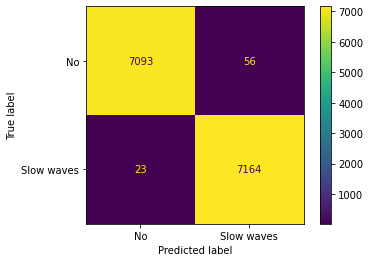

F1 score = 0.994517


In [5]:
import sklearn.metrics as skmetrics
import matplotlib.pyplot as plt

cm = skmetrics.confusion_matrix(df['Label class'], df['Prediction'], labels=[0, 1])
cm_map = skmetrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Slow waves'])
cm_map.plot()
plt.show()

f1 = skmetrics.f1_score(df['Label class'], df['Prediction'])
print('F1 score = {:f}'.format(f1))

## Evaluate slow wave activation time (AT) prediction

In [6]:
r2 = skmetrics.r2_score(df['Label AT'], df['Predicted AT'])
mae = skmetrics.mean_absolute_error(df['Label AT'], df['Predicted AT'])

print('R2 score = {:f}'.format(r2))
print('Mean absolute error = {:f} s'.format(mae))

R2 score = 0.977309
Mean absolute error = 0.109157 s


The r2 score is close to 1. That means, our model can predict the slow wave activation time way better than just giving the mean. There is a 0.13 s error in the predicted activation times.

What is the error distribution like? Do errors come from slow waves being at the edges of the scalogram?

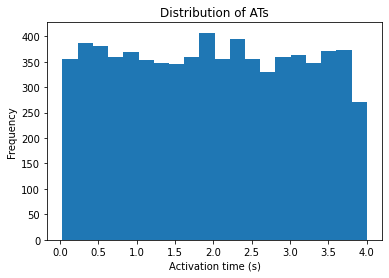

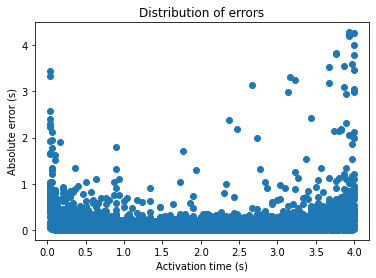

In [7]:
# Find the distribution of activation times in the dataset.

import matplotlib.pyplot as plt

label_AT = df['Label AT']
AT_error =abs(df['Label AT'] - df['Predicted AT'])

AT_error = AT_error[label_AT != -1]
label_AT = label_AT[label_AT != -1]

plt.hist(x=label_AT, bins='auto')
plt.xlabel('Activation time (s)')
plt.ylabel('Frequency')
plt.title('Distribution of ATs')
plt.show()

plt.scatter(x=label_AT, y=AT_error)
plt.xlabel('Activation time (s)')
plt.ylabel('Absolute error (s)')
plt.title('Distribution of errors')
plt.show()

The error in activation times seems to be higher when the slow wave is closer to the edges of the scalogram.

Is the error high because there are multiple slow waves in the scalogram?

In [8]:
df['Number of slow waves'].value_counts()

0    7149
1    7065
2     122
Name: Number of slow waves, dtype: int64

In [9]:
single_sw_df = df[df['Number of slow waves'] == 1]
double_sw_df = df[df['Number of slow waves'] == 2]

for key, curr_df in {'single': single_sw_df, 'double': double_sw_df}.items():
    # F1 score
    f1 = skmetrics.f1_score(curr_df['Label class'], curr_df['Prediction'])
    print('{:s} F1 score = {:f}'.format(key, f1))

    # AT mean absolute error
    mae = skmetrics.mean_absolute_error(curr_df['Label AT'], curr_df['Predicted AT'])
    print('{:s} Mean absolute error = {:f} s'.format(key, mae))

single F1 score = 0.998512
single Mean absolute error = 0.121886 s
double F1 score = 0.991736
double Mean absolute error = 0.512288 s


Error increases to 0.5 s when there are multiple slow waves in the window. However, that seems alright. 

Then, what type of inputs have high error?

In [12]:
df_with_error = df.copy()
label_AT = df_with_error['Label AT']
AT_error = abs(df_with_error['Label AT'] - df_with_error['Predicted AT'])

AT_error = AT_error[label_AT != -1]
df_with_error = df_with_error[label_AT != -1]

df_with_error['AT error'] = AT_error
df_with_error.sort_values('AT error', ascending=False, inplace=True)
df_with_error.head(20)

,Image name,Label class,Number of slow waves,Label AT,No slow wave prob,Slow wave prob,Prediction,Predicted AT,AT error
1949,11332.png,1,1,3.933333,0.430837,0.569163,1,-0.345865,4.279198
4267,24127.png,1,1,4.000000,0.702104,0.297896,0,-0.260668,4.260668
9395,31702.png,1,1,3.933333,0.003064,0.996936,1,-0.301074,4.234407
10199,15170.png,1,1,3.933333,0.922285,0.077715,0,-0.256208,4.189542
8732,28778.png,1,1,4.000000,0.005232,0.994768,1,-0.000547,4.000547
2172,17799.png,1,1,3.766667,0.738940,0.261060,0,-0.068997,3.835664
6330,17714.png,1,1,3.766667,0.574459,0.425541,0,-0.037862,3.804529
12916,24522.png,1,1,4.000000,0.751438,0.248562,0,0.202807,3.797193
29,12332.png,1,1,3.966667,0.636100,0.363900,0,0.365402,3.601264
8880,17713.png,1,1,3.866667,0.249021,0.750979,1,0.322458,3.544208


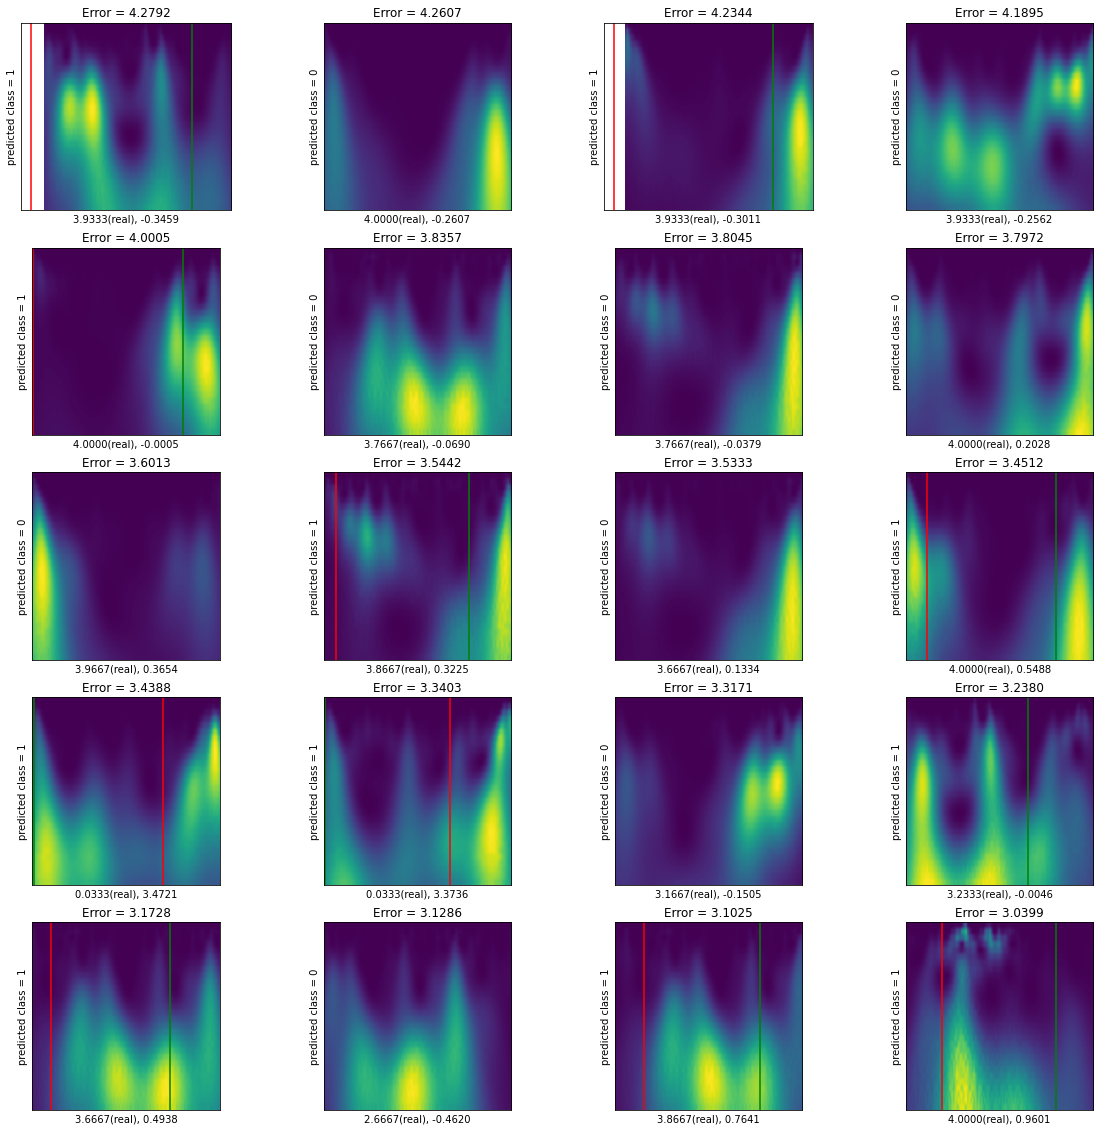

In [14]:
import os
import math
from PIL import Image

curr_df = df_with_error #df_with_error[(df_with_error['Label AT'] > 0.5) & (df_with_error['Label AT'] < 3)]

PLOTS_PER_ROW = 4
num_plots = 20

plt.rcParams["figure.figsize"] = (20, 20) # (w, h)
fig, ax = plt.subplots(nrows=math.ceil(num_plots/PLOTS_PER_ROW), ncols=PLOTS_PER_ROW)

i = 0
for index, row in curr_df.iterrows():
    if i >= num_plots:
        break
        
    r = i // PLOTS_PER_ROW
    c = i % PLOTS_PER_ROW
    
    img = Image.open(os.path.join('../data/SeqSlowWaveDataset/version_3_mini/', row['Image name']))
    img = img.convert('RGB')
    ax[r, c].imshow(img)
    #ax[r, c].set_axis_off()
    ax[r, c].set_xticks([])
    ax[r, c].set_yticks([])
    ax[r, c].set_title('Error = {:.4f}'.format(row['AT error']))
    ax[r, c].set_xlabel('{:.4f}(real), {:.4f}'.format(row['Label AT'], row['Predicted AT']))
    ax[r, c].set_ylabel('predicted class = {:d}'.format(row['Prediction']))
    
    p_x = 224 * row['Predicted AT'] / 5 # predicted point
    l_x = 224 * row['Label AT'] / 5     # Label AT point
    
    if row['Prediction'] == 1:
        ax[r, c].axvline(p_x, color='r')
        ax[r, c].axvline(l_x, color='g')
    
    i += 1
    


The higher errors in predicted ATs are associated with complex scalograms, which is good. Now, even the incorrectly predicted ATs make sense (they detect some high energy region). 

+ Maybe more data could improve the model. 
+ Having a fixed colormap limit for the scalograms could also help.
+ We can also try to include the electrical traces with the scalograms to see if that improves accuracy.

In [ ]:
img.size